In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 99)

### Remove original columns that have been ordinalized

In [3]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Drop Features due to perfect multicollinearity
- Not required for tree-based model but it improves efficiency by having fewer features and interpretability (the feature importance scores will be split among all of the features with perfect multicollinearity).

In [4]:
multi_todrop = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'
               ]

In [5]:
df = df.drop(multi_todrop, axis = 1)

### Dummify Nominal Features

In [6]:
categ_nom = ['MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
             'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
             'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
             'Alley','condition','Foundation','Utilities','Heating',
             'CentralAir','MoSold','Electrical','QrtSold']

In [7]:
df = pd.get_dummies(df, columns=categ_nom, drop_first=True)

### Perform Train / Test Split
- I used the data from 2006 to 2009 for training and 2010 for testing because it mimics a real-world scenario perfectly. It ensures my model is being evaluated on its ability to predict future, unseen data.
- I also dropped column 'YrSold' when training the data because the model might learn that homes sold in 2010 have a particular characteristic that is a direct result of the year itself (e.g., a general market trend or a single large event), rather than a true feature of the house. This makes the model less generalizable to future years. Features that have been derived from 'YrSold' such as 'age_at_sale', 'years_since_remod' and 'garage_age_derived' are directly related to the house, not the time of the market and it also avoids data leakage from the year itself.

In [8]:
X = df.drop(['SalePrice', 'PID', 'YrSold'], axis = 1)
y = df['SalePrice']

In [9]:
# Split the data into train and test based on the year the house was sold
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

X_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)].drop(['SalePrice', 'PID', 'YrSold'], axis = 1)
X_test = df.loc[df['YrSold'].astype(int) == 2010].drop(['SalePrice', 'PID', 'YrSold'], axis = 1)

y_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)]['SalePrice']
y_test = df.loc[df['YrSold'].astype(int) == 2010]['SalePrice']

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat the train/test split multiple times and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [10]:
model_baseline = RandomForestRegressor(random_state=42)

In [11]:
model_baseline.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# evaluate untuned / baseline model
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

# R2
r2_baseline_train = model_baseline.score(X_train, y_train)
r2_baseline_test = model_baseline.score(X_test, y_test)

print(f"Train R square: {r2_baseline_train:.4f}")
print(f"Test R square: {r2_baseline_test:.4f}")

# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_baseline_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_baseline_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train Root Mean Squared Error: {rmse_baseline_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_baseline_test:.2f}")

Train R square: 0.9863
Test R square: 0.8982
Train Root Mean Squared Error: 8838.60
Test Root Mean Squared Error: 23714.02


In [13]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize baseline model
model = RandomForestRegressor(random_state=42)

# Lists to store the scores and RMSE values
scores = []
rmse_values = []

# Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.8961
Average baseline RMSE: $24191.55
Standard deviation of RMSE: $3158.16


## Hyperparameter Tuning

In [14]:
# param_grid = {
#     'n_estimators': range(50, 300, 50),
#     'max_depth': range(3,24,3),
#     'min_samples_split': range(5,20,5),
#     'min_samples_leaf': range(1,10),
#     'max_features': range(20, 100, 20)
# }

In [15]:
# model = RandomForestRegressor(random_state=42)

# grid_search_rf = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=5,
#                            n_jobs=-1,
#                            verbose=0,
#                            scoring='r2')

# grid_search_rf.fit(X_train, y_train)
# %time grid_search_rf.fit(X_train, y_train)

In [16]:
import optuna
from optuna.samplers import TPESampler

In [57]:
# It's a good practice to set up logging to see Optuna's progress
optuna.logging.set_verbosity(optuna.logging.INFO)

#X_tra, X_val, y_tra, y_val
def objective(trial):
    """
    This function defines the search space for Optuna. It suggests hyperparameters,
    trains the model on the training set, evaluates it on the validation set, and returns
    a single value to be optimized (R-squared score).

    Args:
        trial (optuna.trial.Trial): The trial object that suggests hyperparameters.
        X_tra (pd.DataFrame): Training feature matrix.
        X_val (pd.DataFrame): Validation feature matrix.
        y_tra (pd.Series): Training target vector.
        y_val (pd.Series): Validation target vector.

    Returns:
        float: The R-squared score on the validation set.
    """
    # Define the search space for the hyperparameters using trial.suggest_...
#     param = {

#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        
#         'max_depth': trial.suggest_int('max_depth', 5, 50, log=True),
        
#         'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
        
#         'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
        
#         #'max_features': trial.suggest_int("max_features", 2, 100), 
#         'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),
        
#         'verbose': 0
#     }

    param = {
    # 'n_estimators': Keep this range. A higher number of trees can help reduce variance.
    'n_estimators': trial.suggest_int('n_estimators', 100, 2000),

    # determines the maximum depth of each individual tree in random forest
    'max_depth': trial.suggest_int('max_depth', 2, 50, log=True),

    # 'min_samples_split': The current range is reasonable.
    'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),

    # sets the minomum number of data points that must be present in a leaf node after a split
    # 'min_samples_leaf': The current range is reasonable.
    'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),

    # max_features controls the number of features that each tree considers when looking for the best split at each node
    # 'max_features': The current range is already good for preventing underfitting.
    'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 1.0]),
    
    'verbose': 0
}


    # Implementing Repeated K-Fold Cross-Validation
    n_splits = 5
    n_repeats = 3
    rkf = RepeatedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=42) 
    
    r2_scores = []
    
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]    
    
    
    # Initialize the RandomForest Regressor with the parameters suggested by the trial
    model = RandomForestRegressor(**param, random_state = 42, n_jobs=-1)

    # Train the model on the training data
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation data
    y_pred = model.predict(X_val_fold)
    
    # Calculate the R-squared score on the validation set
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)

    # Optuna needs a single value to optimize, so we return the R-squared score
    return np.mean(r2_scores)

In [58]:
# --- Create the Optuna study and run the optimization ---
# We want to maximize the R-squared score, so we set direction='maximize'
# We explicitly use TPESampler as requested.
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

print("Starting Optuna optimization for hyperparameter tuning...")
# Run the optimization for a specified number of trials.
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Print the results ---
print("-" * 30)
print("Optuna optimization completed.")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best R-squared score found: {study.best_value:.4f}")
print("\nBest parameters found:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

[I 2025-09-21 16:00:37,224] A new study created in memory with name: no-name-88667b40-8e34-47a4-a092-b445e4a1e119


Starting Optuna optimization for hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-21 16:00:38,757] Trial 0 finished with value: 0.895490588830924 and parameters: {'n_estimators': 812, 'max_depth': 42, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 1.0}. Best is trial 0 with value: 0.895490588830924.
[I 2025-09-21 16:00:39,391] Trial 1 finished with value: 0.8685723504404524 and parameters: {'n_estimators': 1242, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.895490588830924.
[I 2025-09-21 16:00:39,750] Trial 2 finished with value: 0.8863005821988206 and parameters: {'n_estimators': 678, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.895490588830924.
[I 2025-09-21 16:00:41,237] Trial 3 finished with value: 0.90515908060627 and parameters: {'n_estimators': 966, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.8}. Best is trial 3 with value: 0.90515908060627.
[I 2025

[I 2025-09-21 16:01:48,271] Trial 33 finished with value: 0.9090140252829054 and parameters: {'n_estimators': 1996, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.8}. Best is trial 32 with value: 0.9143819159928407.
[I 2025-09-21 16:01:49,343] Trial 34 finished with value: 0.9023945784103935 and parameters: {'n_estimators': 1830, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.9143819159928407.
[I 2025-09-21 16:01:52,008] Trial 35 finished with value: 0.9047742636938478 and parameters: {'n_estimators': 1869, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.8}. Best is trial 32 with value: 0.9143819159928407.
[I 2025-09-21 16:01:54,844] Trial 36 finished with value: 0.9082678836935462 and parameters: {'n_estimators': 1687, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.8}. Best is trial 32 with value: 0.914381915992

In [59]:
study.best_params

{'n_estimators': 1997,
 'max_depth': 14,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 0.8}

### Hyperparameter Importances Plot
- This plot shows you which hyperparameters were most influential in determining the model's performance during the optimization process. The importance is calculated by analyzing how much each parameter's value impacted the final R-squared score.

- Essentially, if a hyperparameter like learning_rate or depth has a high importance score, it means that changes to its value led to significant changes in the model's performance. Conversely, a parameter with a low importance score means that varying its value didn't have much effect on the final outcome.

- This plot is incredibly useful for refining your next optimization. For instance, if you see that a certain hyperparameter has very low importance, you might be able to fix its value or remove it from the search space in a future run to make the optimization faster and more efficient.

In [60]:
optuna.visualization.plot_param_importances(study)

### Optimization History Plot
- This plot helps you understand if your optimization is making good progress or if it has reached its full potential.

- Trial-by-Trial Performance: Each dot on the plot represents a single trial (one set of hyperparameters) and its corresponding objective value (the R-squared score in your case). This shows you how the model performed with different parameter combinations.

- Progress Over Time: The x-axis represents the trial number. As you move from left to right, you can see how the performance of the trials changes over the course of the optimization.

- Convergence: The most important part of this plot is the "best value so far" line. This line shows the highest R-squared score found up to each trial. If this line starts to flatten out and doesn't improve much over the last few trials, it's a strong indicator that the optimization has converged. This can tell you that running more trials might not be necessary to find a better solution.

In [61]:
optuna.visualization.plot_optimization_history(study)

### Run Repeated K-fold cross-validation on the entire dataset with the best hyperparameters
- By running K-fold cross-validation on the entire dataset with the best hyperparameters, you are training and evaluating the model on multiple different data splits. The average score across all folds gives you a much more robust and less optimistic R-squared value that better reflects the model's true generalization performance. It essentially removes the bias of a single train/test split.

In [22]:
# --- Cross-Validation with Final Model ---
print("\n" + "="*50)
print("Performing K-fold Cross-Validation with the Final Model...")
print("="*50)

# Re-instantiate the final model with best parameters
final_model = RandomForestRegressor(
    **study.best_params,
    random_state=42
)

# Implementing Repeated K-Fold Cross-Validation

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

scoring = {'r2': 'r2',
           'neg_RMSE': 'neg_root_mean_squared_error'
          }


# Perform cross-validation and get the R-squared scores
# We use the full dataset (X, y) for cross-validation
cv_scores = cross_validate(final_model, X, y, cv=rkf, scoring=scoring, n_jobs=-1)

# Print the results for each metric
print("\nCross-Validation Results:")
for metric_name, score_array in cv_scores.items():
    if metric_name.startswith('test_'):
        display_name = metric_name.replace('test_', '')
        print(f"  Validation {display_name} scores: {np.round(score_array, 4)}")
        print(f"  Mean Validation {display_name} score: {np.mean(score_array):.4f}")
        print(f"  Standard deviation of {display_name} score: {np.std(score_array):.4f}")
        print("-" * 30)


Performing K-fold Cross-Validation with the Final Model...

Cross-Validation Results:
  Validation r2 scores: [0.9332 0.8985 0.9028 0.9235 0.8452 0.9125 0.9213 0.8671 0.8859 0.9215
 0.8992 0.9345 0.9205 0.904  0.8363]
  Mean Validation r2 score: 0.9004
  Standard deviation of r2 score: 0.0291
------------------------------
  Validation neg_RMSE scores: [-21105.5817 -25884.8436 -21422.7001 -20913.5074 -26844.387  -23904.1459
 -20495.6715 -27301.8057 -25823.0598 -19921.5046 -24688.6335 -17190.7347
 -22620.4012 -24288.8774 -29175.4351]
  Mean Validation neg_RMSE score: -23438.7526
  Standard deviation of neg_RMSE score: 3164.6595
------------------------------


In [23]:
pd.DataFrame(cv_scores).describe()

,fit_time,score_time,test_r2,test_neg_RMSE
count,15.000000,15.000000,15.000000,15.000000
mean,37.260201,0.384932,0.900399,-23438.752620
std,0.611696,0.073810,0.030122,3275.733747
min,36.511794,0.243274,0.836289,-29175.435134
25%,36.611188,0.342584,0.892239,-25853.951684
50%,37.481312,0.395157,0.903992,-23904.145878
75%,37.801903,0.438325,0.921387,-21009.544553
max,38.211376,0.523002,0.934475,-17190.734712


In [24]:
# Get the mean R-squared from the cross-validation results
cv_r2_mean = np.mean(cv_scores['test_r2'])

### Evaluate on Test Set

In [25]:
# Retrain the model using the best hyperparameters found by Optuna
final_model = RandomForestRegressor(
    **study.best_params,
    random_state=42
)

final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=34, max_features=0.8, min_samples_split=3,
                      n_estimators=1868, random_state=42)

In [26]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final RMSE on the train set: ${final_rmse_train:.4f}")
print(f"Final RMSE on the test set: ${final_rmse_test:.4f}")

# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Final RMSE on the train set: $9049.2045
Final RMSE on the test set: $23191.9375
Train R square: 0.9856
Test R square: 0.9026


### Extract Feature Importance

In [27]:
feature_importance_final = pd.DataFrame({"feature": X.columns, 
                                            "importance_rf_5fk":final_model.feature_importances_})

In [28]:
feature_importance_final.sort_values("importance_rf_5fk", ascending = False, inplace=True);
feature_importance_final.head(10)

,feature,importance_rf_5fk
3,OverallQual,0.495814
0,GrLivArea,0.151211
6,TotalBsmtSF,0.069257
37,ExterQual_ordinal,0.038067
15,GarageCars,0.037126
16,GarageArea,0.022941
2,LotArea,0.018368
9,FullBath,0.014235
40,age_at_sale,0.013436
5,MasVnrArea,0.012496


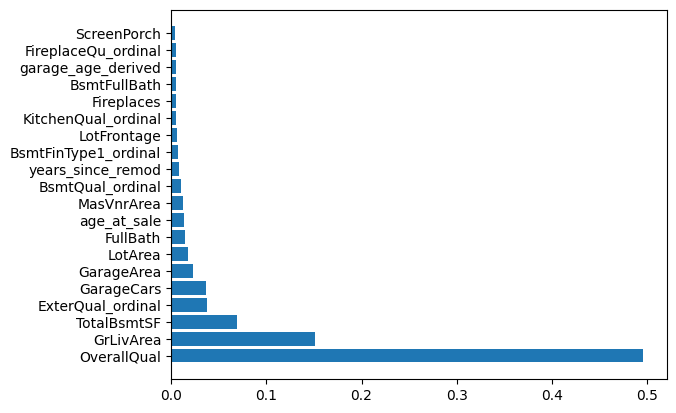

In [29]:
temp = feature_importance_final.iloc[:20,]
plt.barh(temp["feature"], temp["importance_rf_5fk"]);

## Model Evaluation

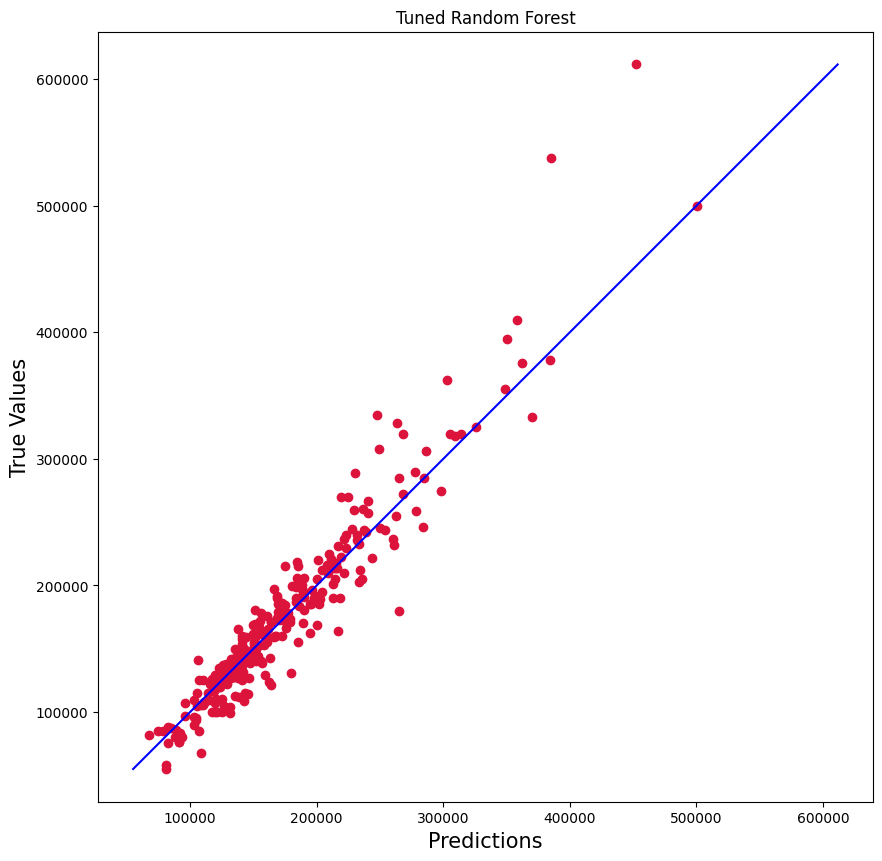

In [30]:
# Plot y_test vs y_test_pred

plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned Random Forest')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### Residual Plot
- After training your final CatBoost model and using it to make predictions on the test set, you can generate a residual plot to visually inspect its performance. This type of plot is a valuable tool for understanding if your model's errors are random or if there are systematic patterns.

- The plot below shows the relationship between your model's predicted values and the residuals (the difference between the actual and predicted values).

- An ideal residual plot will show a random, uniform scatter of points around the horizontal line at y=0. This indicates that your model's errors are random and are not related to the predicted value. It means your model is not systematically over- or under-predicting for certain ranges of house prices.

- In contrast, if you see a discernible pattern in the plot (e.g., a fanning-out shape, a curve, or a clear concentration of points), it suggests that your model may have a bias. For example, a fanning-out pattern could mean that the model's errors increase as the predicted price gets higher, indicating a need for a more complex model or additional features to handle higher-priced homes.

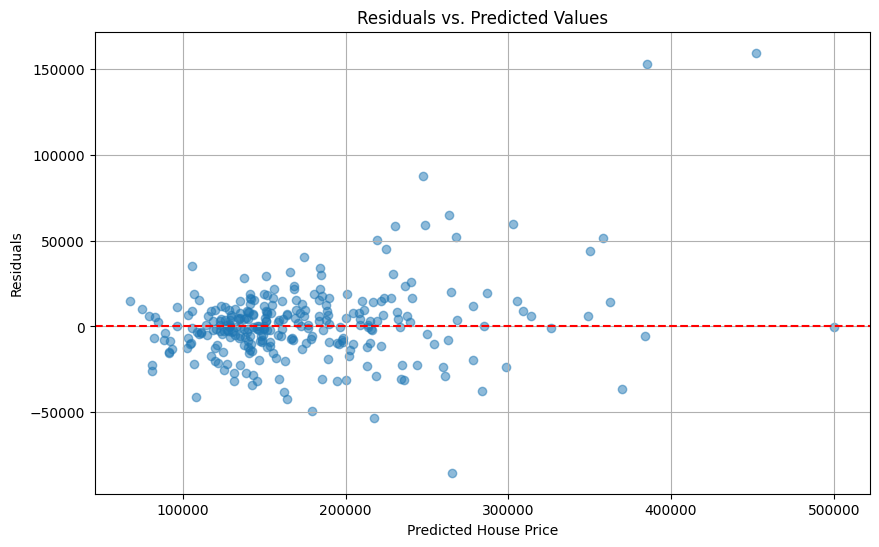

In [31]:
# Plot Residuals vs. Predicted Values

residuals = y_test - y_test_pred

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig('residuals_plot.png')

#print("Residuals plot has been generated and saved as 'residuals_plot.png'.")

### Distribution of actual house prices, y_test and y_test_pred
- Overlap: The more the two distributions overlap, the better your model's predictions align with the actual values. An ideal model's y_pred distribution will closely mimic the y_test distribution.

- Shape: The shapes of the two distributions should be similar. If the y_pred distribution is much narrower than the y_test distribution, it means your model is under-predicting the range of prices and is not confident in making predictions for the highest or lowest-priced homes.

- Skewness: If the actual data is skewed (e.g., towards higher prices), your predicted data should show a similar skew.

In [32]:
# Calculate the mean and standard deviation
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
y_test_pred_mean = np.mean(y_test_pred)
y_test_pred_std = np.std(y_test_pred)

print("Actual Values (y_test) statistics:")
print(f"Mean: {y_test_mean:.4f}")
print(f"Standard Deviation: {y_test_std:.4f}")
print("\nPredicted Values (y_test_pred) statistics:")
print(f"Mean: {y_test_pred_mean:.4f}")
print(f"Standard Deviation: {y_test_pred_std:.4f}")

Actual Values (y_test) statistics:
Mean: 174699.6007
Standard Deviation: 74329.6605

Predicted Values (y_test_pred) statistics:
Mean: 173253.7104
Standard Deviation: 64091.7573


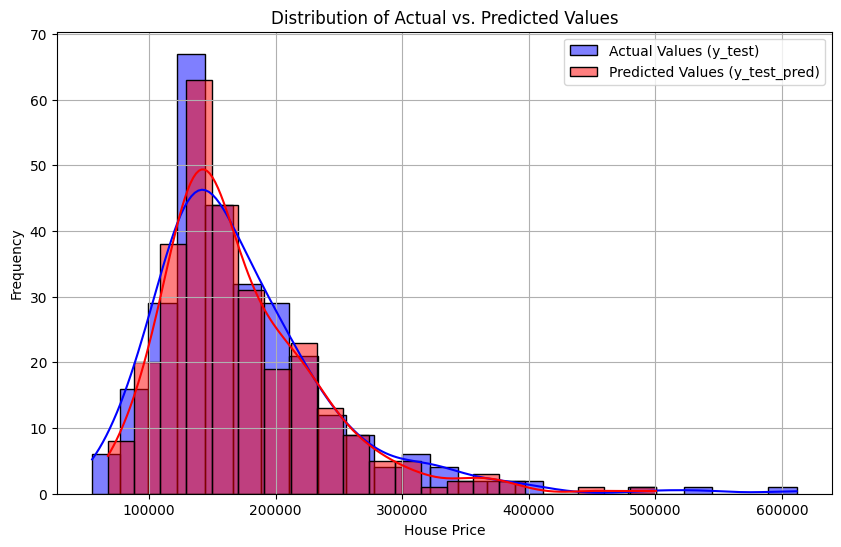

In [33]:
# Plot the distributions of y_test and y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values (y_test)')
sns.histplot(y_test_pred, kde=True, color='red', label='Predicted Values (y_test_pred)')
#sns.histplot(y, kde=True, color='orange', label='Sales Prices (y)')

plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('distribution_plot.png')

#print("Distribution plot has been generated and saved as 'distribution_plot.png'.")

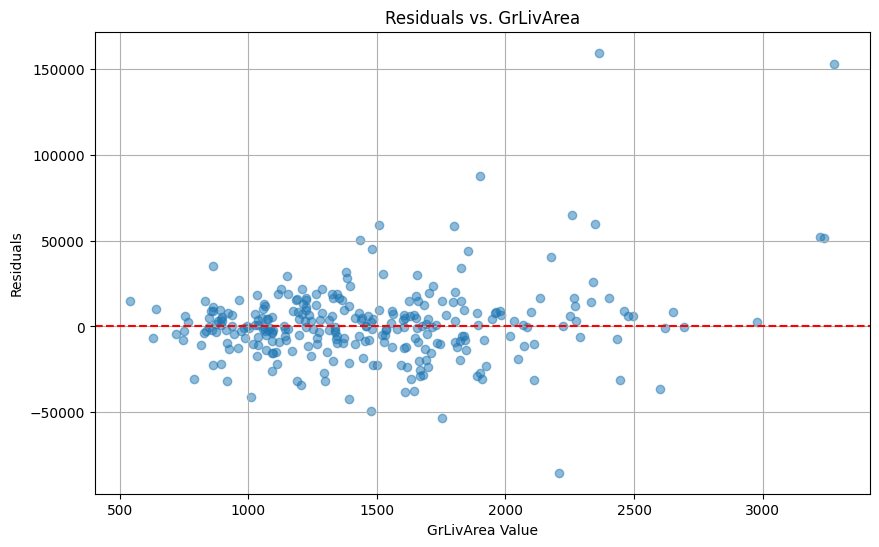

In [34]:
# plot residual vs features

# Choose the feature you want to plot against
feature_to_plot = 'GrLivArea'  # Change this to your desired feature (e.g., 'GrLivArea')
feature_values = X_test[feature_to_plot]

# Create the scatter plot of residuals vs. a chosen feature
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, residuals, alpha=0.5)
plt.title(f'Residuals vs. {feature_to_plot}')
plt.xlabel(f'{feature_to_plot} Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig(f'residuals_vs_{feature_to_plot}.png')

#print(f"Residuals vs. {feature_to_plot} plot has been generated and saved.")

## Model Explainability

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [35]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [36]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_model)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [37]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap_rf_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_rf_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                  feature  mean_abs_shap_rf_5fk
3             OverallQual          24116.861009
0               GrLivArea          17536.207178
6             TotalBsmtSF           7676.761671
37      ExterQual_ordinal           2765.316646
2                 LotArea           2460.710939
40            age_at_sale           2418.126106
35   BsmtFinType1_ordinal           2359.429166
9                FullBath           2217.592625
16             GarageArea           2201.613402
41      years_since_remod           1721.669022
15             GarageCars           1609.238848
7            BsmtFullBath           1393.676214
28    FireplaceQu_ordinal           1309.529571
31    KitchenQual_ordinal           1036.727114
14             Fireplaces            932.283455
32       BsmtQual_ordinal            892.767541
1             LotFrontage            864.185485
4             OverallCond            836.178068
5              MasVnrArea            815.385821
24   GarageFinish_ordinal            805

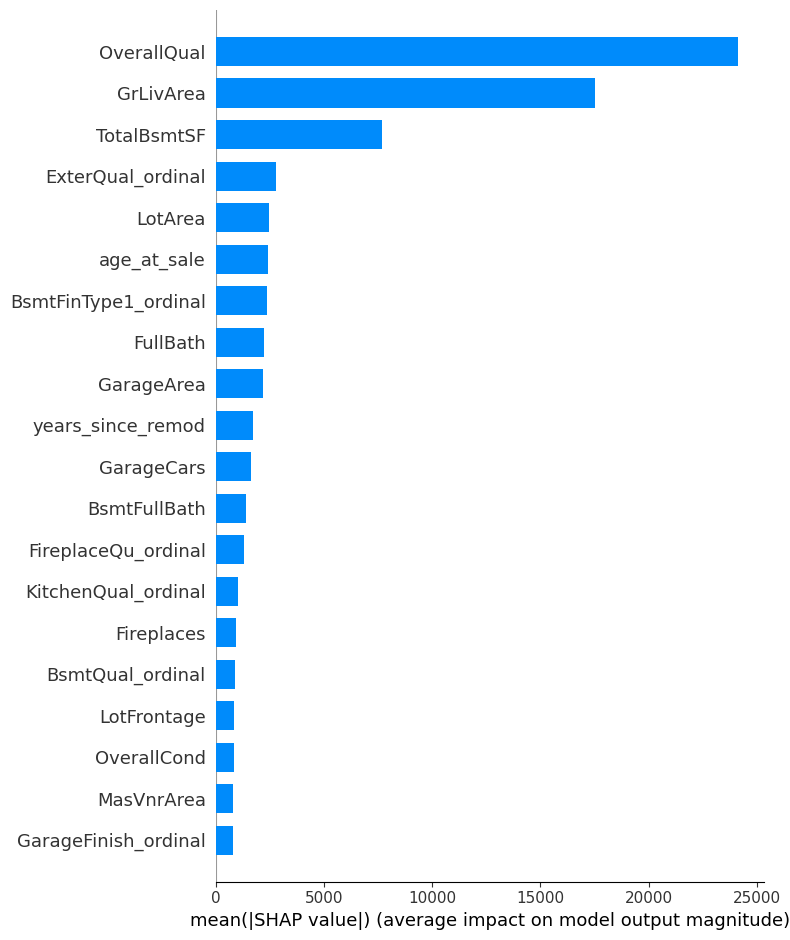

In [38]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

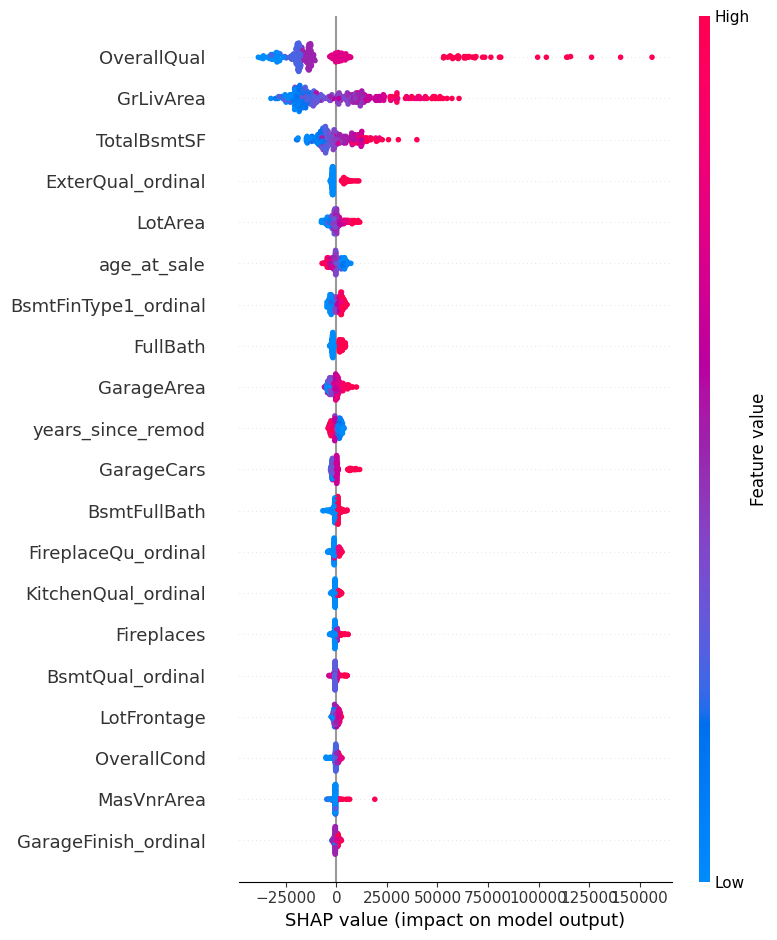

In [39]:
# summary violin plot
shap.summary_plot(shap_values, X_test)

In [40]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

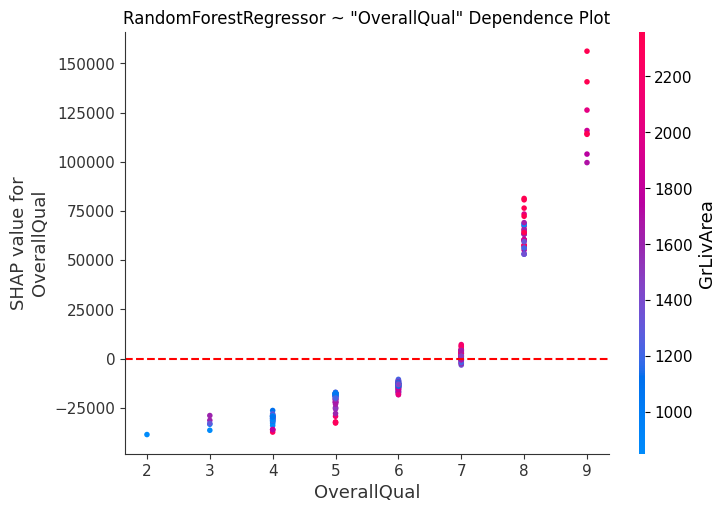

In [66]:
shap.dependence_plot('OverallQual', shap_values, X_test, show=False)

plt.tight_layout()
plt.axhline(y=0, color='red', linestyle='--')
plt.title('RandomForestRegressor ~ "OverallQual" Dependence Plot')
plt.savefig('shap_dep_plot_OverallQual_rf.png', bbox_inches='tight', dpi=300)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

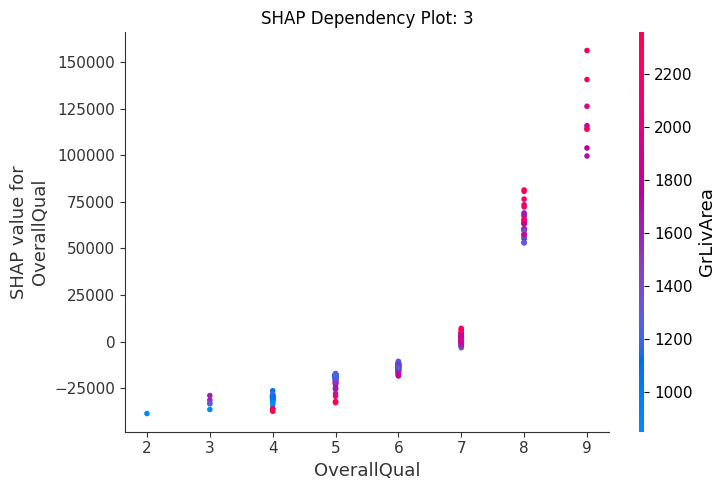

<Figure size 600x400 with 0 Axes>

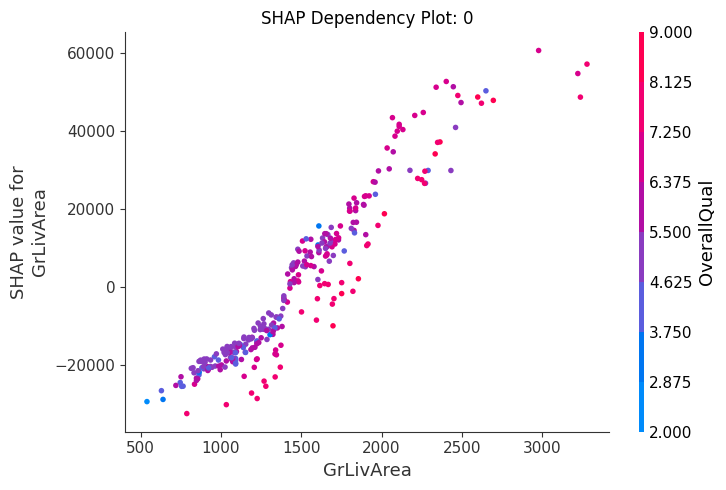

<Figure size 600x400 with 0 Axes>

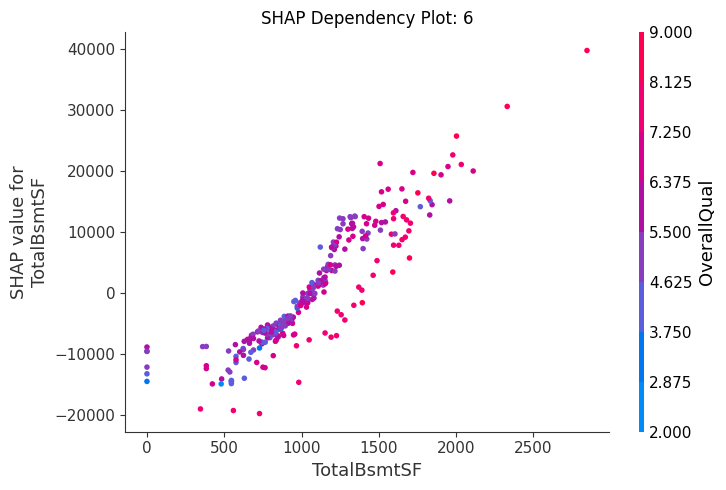

<Figure size 600x400 with 0 Axes>

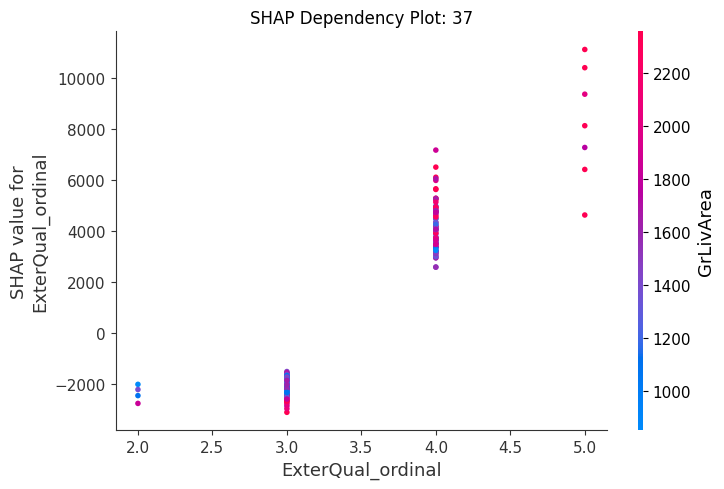

<Figure size 600x400 with 0 Axes>

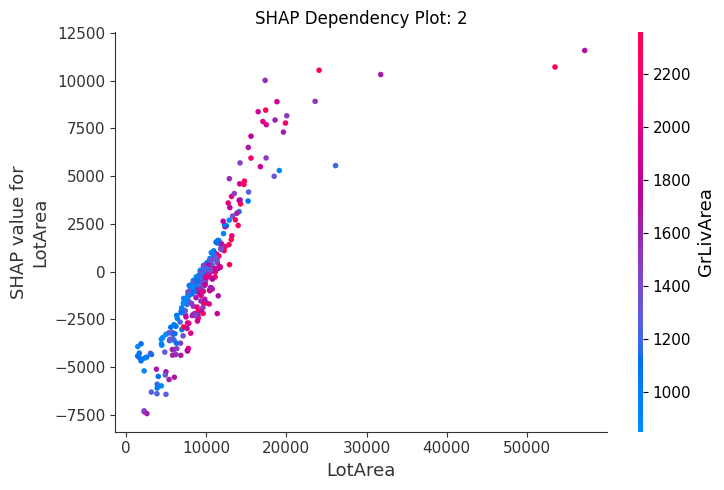

<Figure size 600x400 with 0 Axes>

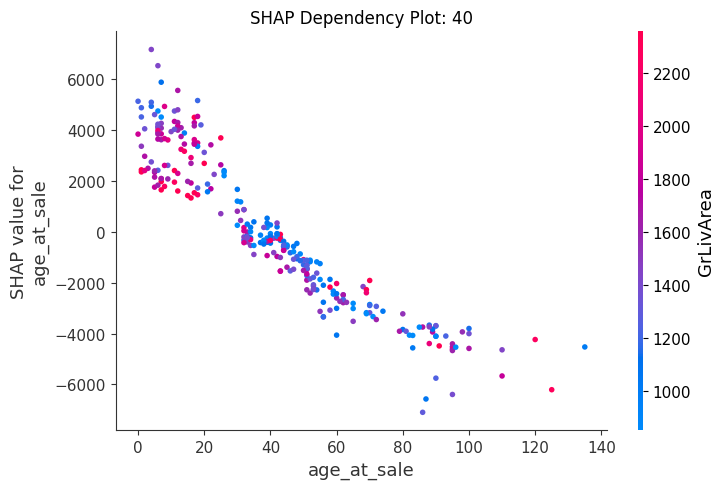

<Figure size 600x400 with 0 Axes>

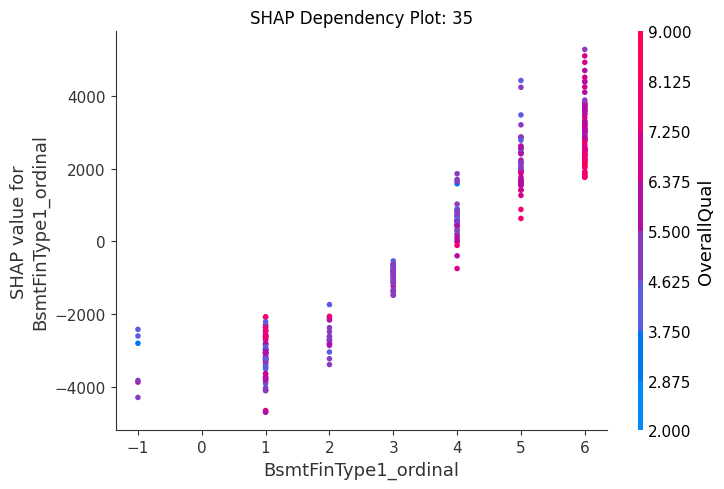

<Figure size 600x400 with 0 Axes>

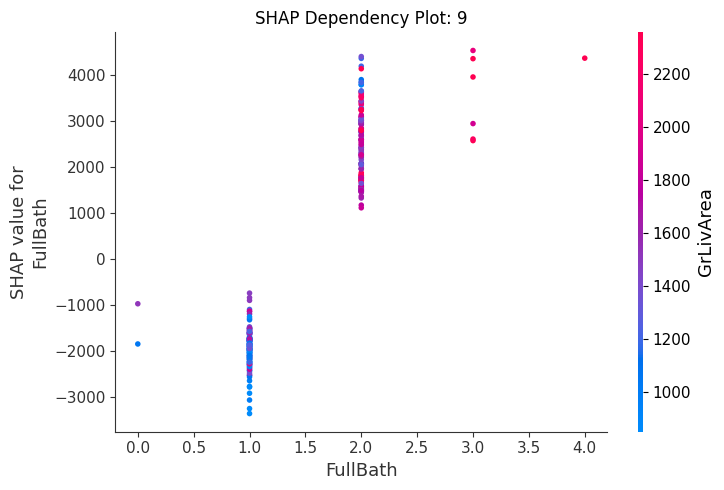

<Figure size 600x400 with 0 Axes>

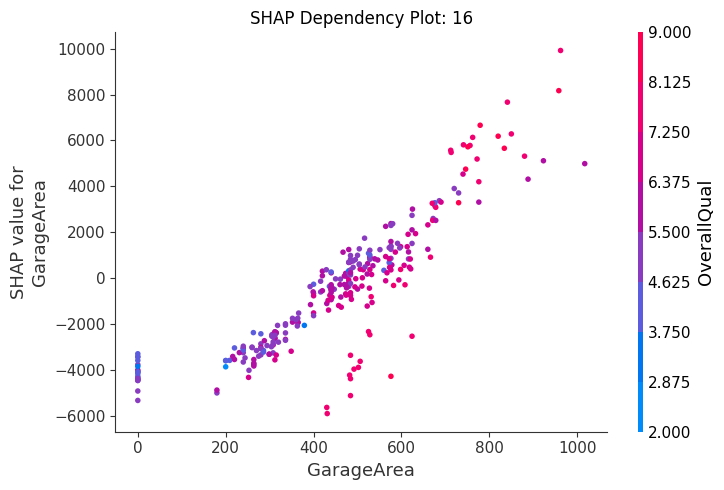

<Figure size 600x400 with 0 Axes>

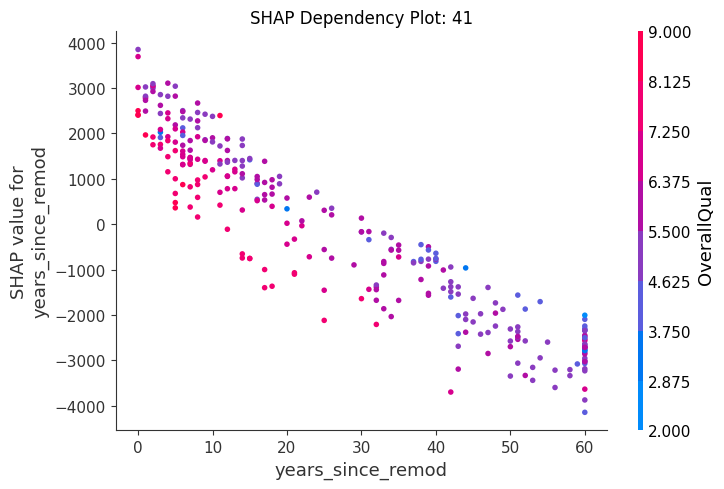

<Figure size 600x400 with 0 Axes>

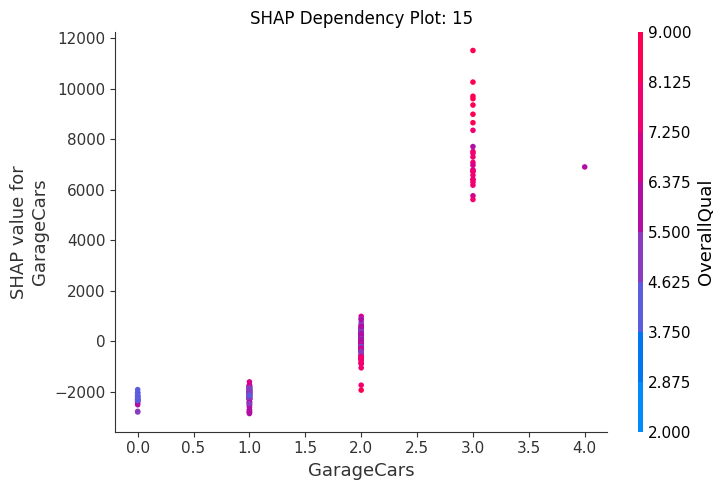

<Figure size 600x400 with 0 Axes>

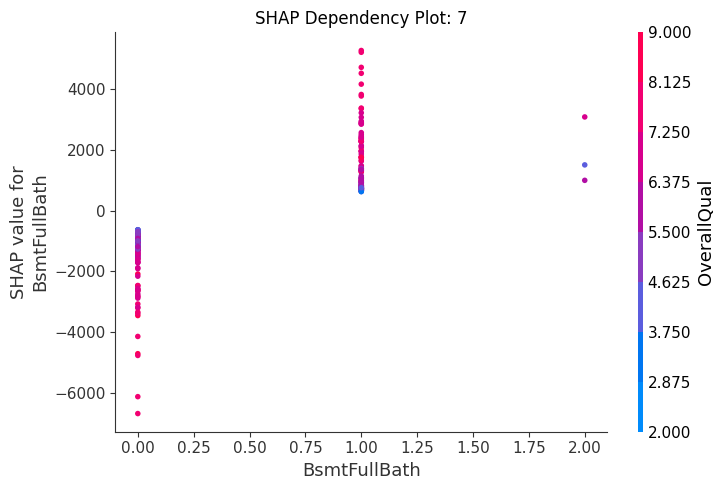

<Figure size 600x400 with 0 Axes>

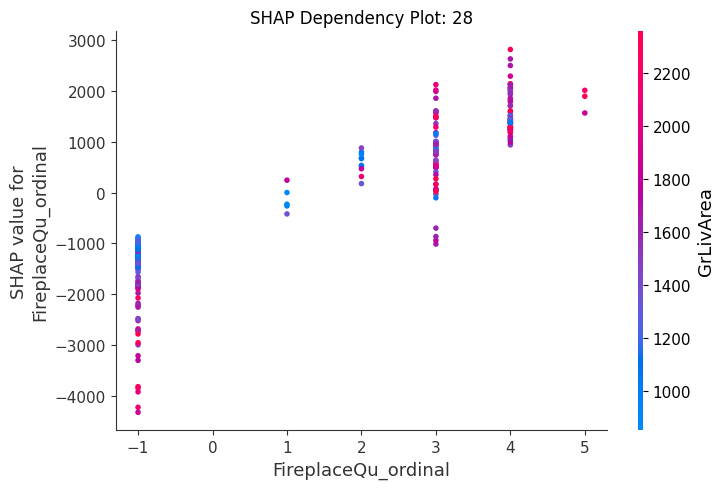

<Figure size 600x400 with 0 Axes>

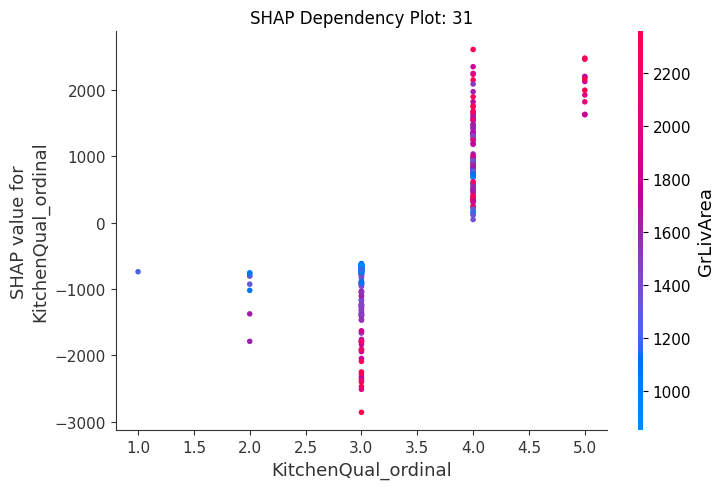

<Figure size 600x400 with 0 Axes>

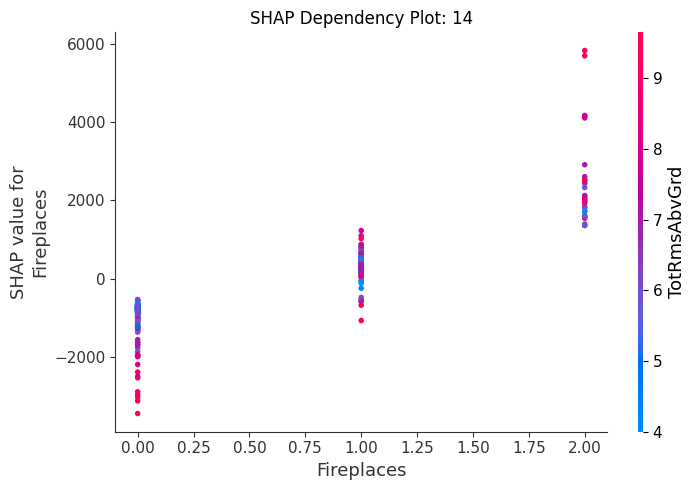

<Figure size 600x400 with 0 Axes>

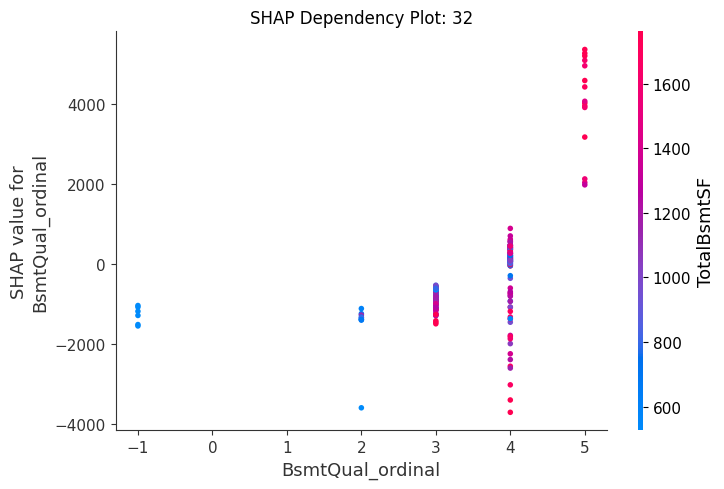

<Figure size 600x400 with 0 Axes>

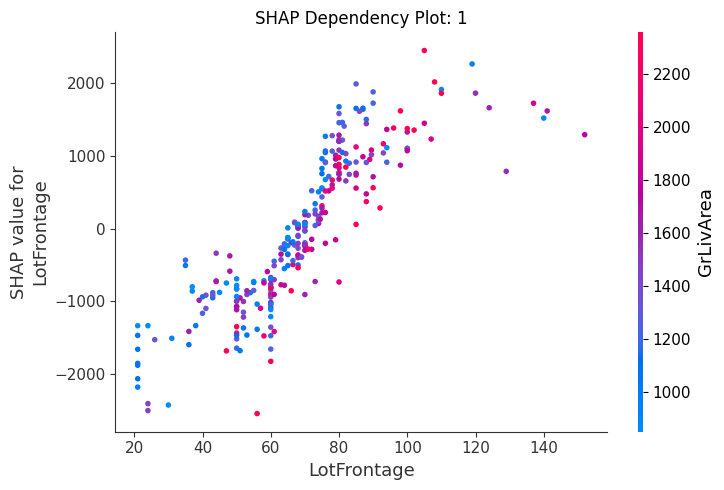

<Figure size 600x400 with 0 Axes>

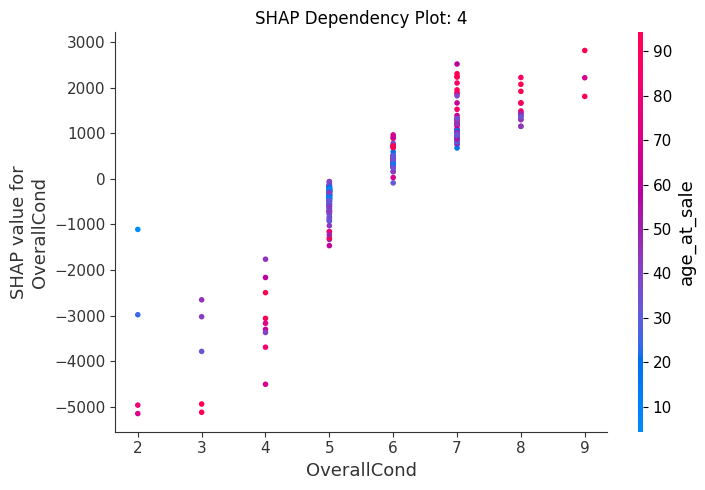

<Figure size 600x400 with 0 Axes>

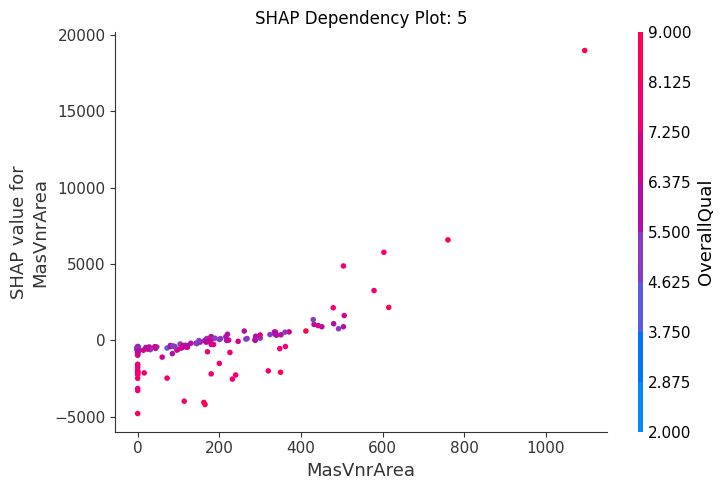

<Figure size 600x400 with 0 Axes>

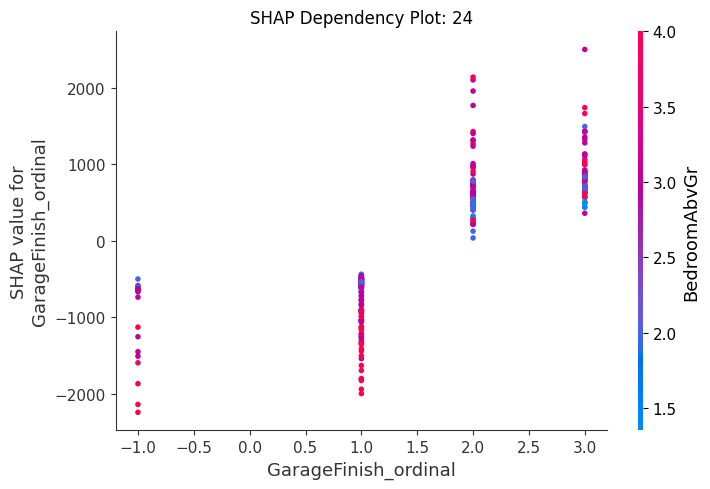

In [42]:
# Select top 20 features
top_features = shap_importance_sorted.head(20)['feature']

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

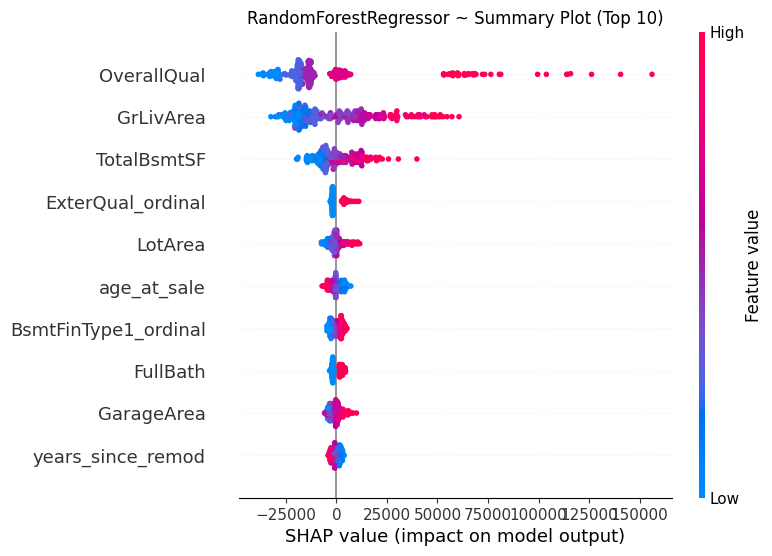

In [65]:
shap.summary_plot(shap_values, X_test, max_display = 10, show=False)
plt.tight_layout()
plt.title('RandomForestRegressor ~ Summary Plot (Top 10)')
plt.savefig('shap_summary_plot_top10_rf.png', bbox_inches='tight', dpi=300)

In [55]:
shap_importance_sorted.drop('index', axis=1).head(5)

,feature,mean_abs_shap_rf_5fk
0,OverallQual,24116.861009
1,GrLivArea,17536.207178
2,TotalBsmtSF,7676.761671
3,ExterQual_ordinal,2765.316646
4,LotArea,2460.710939


In [44]:
# export SHAP importance data into a csv
shap_importance_sorted.reset_index(inplace=True)
shap_importance_sorted.to_csv('shap_importance_rf.csv', index=False)

In [45]:
# Create a new DataFrame that includes the best value from the tuning process as well.
# This addresses the user's specific request.
full_comparison = pd.DataFrame({
    'model': ['RandomForest'] * 3,
    'metric': ['Test_R2', 'Best_Tuned_R2', 'Final_CV_mean_R2'],
    'score': [r2_5kf_test, study.best_value, cv_r2_mean]
})

In [46]:
full_comparison

,model,metric,score
0,RandomForest,Test_R2,0.902647
1,RandomForest,Best_Tuned_R2,0.913890
2,RandomForest,Final_CV_mean_R2,0.900399


In [47]:
# export R2 scores into a csv
full_comparison.reset_index(inplace=True)
full_comparison.to_csv('r2_rf.csv', index=False)

### Extract the list of features and features that each one is most correlated with

In [48]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = X_test.corr()

In [49]:
most_correlated = {}

for feature in X_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature


In [50]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature_rf_5fk']

In [51]:
correlation_df

,feature,most_correlated_feature_rf_5fk
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,LotArea
2,LotArea,exterior_covering_CemntBd_Wd Shng
3,OverallQual,ExterQual_ordinal
4,OverallCond,ExterCond_ordinal
...,...,...
180,MoSold_7,QrtSold_Q3
181,Electrical_FuseF,Electrical_SBrkr
182,Electrical_SBrkr,Electrical_FuseF
183,QrtSold_Q2,MoSold_3


In [52]:
# limit the above list to top 20 features ranked by mean abs SHAP values
rf_SHAP_feature_final = pd.merge(
    shap_importance_sorted, 
    correlation_df, 
    how='left',
    on = 'feature'
)

#rf_SHAP_feature_final = rf_SHAP_feature_final[['model', 'feature', 'most_correlated_feature', 'mean_abs_shap']]
rf_SHAP_feature_final

,index,feature,mean_abs_shap_rf_5fk,most_correlated_feature_rf_5fk
0,3,OverallQual,24116.861009,ExterQual_ordinal
1,0,GrLivArea,17536.207178,TotRmsAbvGrd
2,6,TotalBsmtSF,7676.761671,BsmtQual_ordinal
3,37,ExterQual_ordinal,2765.316646,OverallQual
4,2,LotArea,2460.710939,exterior_covering_CemntBd_Wd Shng
...,...,...,...,...
267,122,exterior_covering_CemntBd_Wd Shng,0.000000,LotArea
268,151,exterior_covering_Stucco_CmentBd,0.000000,Neighborhood_Timber
269,157,exterior_covering_VinylSd_AsbShng,0.000000,MSSubClass_190
270,158,exterior_covering_VinylSd_HdBoard,0.000000,Neighborhood_Sawyer
